In [84]:
import warnings
warnings.filterwarnings('ignore')

#设置绘图风格
style.use("fivethirtyeight")

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr



ModuleNotFoundError: No module named 'graphviz'

# 不加任何control的回归

In [85]:
# 1.读取数据
data=pd.read_csv("C:/Users/62678/Desktop/Causal/data/collections_email.csv")
data.head()

,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479
3,770,0,0.0,0.0,1531.828576,0.560488
4,660,0,0.0,0.0,979.855647,0.455140


In [86]:
# 2.计算ATE
#先使用手动计算均值（分组求均值）
group_mean=data.groupby("email").agg({"payments":"mean"}).reset_index()  # 先group，再select(agg)--- 出来还是一个表dataframe
print(group_mean)
# ATE= group_mean.query("email==1").payments or ATE= group_mean.query("email==1")["payments"]  # 先where（query）,再select([])----出来还是一个表
# 取值还是要用loc
ATE= group_mean.loc[1,"payments"]- group_mean.loc[0,"payments"]
print(f"ATE is:",{ATE})
print(f"ATE is: {ATE}")

   email    payments
0      0  669.976434
1      1  669.356153
ATE is: {-0.6202804021329484}
ATE is: -0.6202804021329484


In [87]:
#再使用线性回归
model_1=smf.ols("payments~ email",data=data).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,669.9764,2.061,325.116,0.000,665.937,674.016
email,-0.6203,2.941,-0.211,0.833,-6.387,5.146


Text(0.5,1,'Payments~email')

<Figure size 576x288 with 0 Axes>

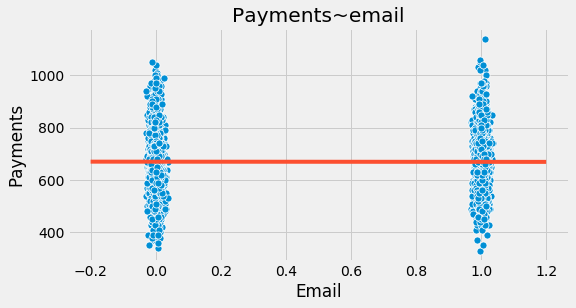

In [83]:
# 3.查看下散点图,和线性回归的图
plt.figure(figsize=(8,4))
#sns.scatterplot("email","payments",data=data,s=50)

# 给Email加一点随机噪声（就是让Email+随机数）
np.random.seed(100)
new_email=data.email + np.random.normal(0,0.01,size=len(data.email))  # 让email 在 0 和 1 附近波动
data=data.assign(new_email=new_email)  # assign 可以创建新行，也可以赋值
data.head()

# 先画出x,y 的散点图
plt.figure(figsize=(8,4))
sns.scatterplot("new_email","payments",data=data,s=50)

# 再画出线性回归曲线
x=np.linspace(-0.2,1.2) # -0.2 到1.2之间的等比数列(arry)
y=model_1.params[0]+model_1.params[1]*x   
plt.plot(x,y,c="C1")  # s=size. c=color

# 加图例
plt.xlabel("Email")
plt.ylabel("Payments")
plt.title("Payments~email")

# 1.加入好的confunder（confunder影响T , 也影响 Y）

In [ ]:
# 线性回归模型的参数(x,y,y_hat,resid,beta0,beta1)
#model_email.fittedvalues
#model_email.resid
#model_email.params[0]
#model_email.params[1]

In [105]:
# 1. 加入control分步进行回归
# 先检测 （control 对于T  自变量的解释 T~ control）
model_email=smf.ols("email~credit_limit + risk_score",data=data).fit()
print(model_email.summary().tables[1])

# 再检测（control对于 Y 的解释力 Y ~ control）
model_payments=smf.ols("payments~credit_limit + risk_score",data=data).fit()
print(model_payments.summary().tables[1])

# 将两个模型的residual 存为dataframe
residuals=pd.DataFrame(dict(res_payments=model_payments.resid,res_email=model_email.resid))
print(residuals.head())

#将两个resid 进行回归
model_treatment=smf.ols("res_payments~ res_email",data=residuals).fit()
print(model_treatment.summary().tables[1])

                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3548      0.064      5.515      0.000       0.229       0.481
credit_limit    -0.0002   5.32e-05     -3.490      0.000      -0.000   -8.14e-05
risk_score       0.7444      0.255      2.919      0.004       0.245       1.244
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      492.4370      9.689     50.825      0.000     473.443     511.431
credit_limit     0.1502      0.008     18.747      0.000       0.135       0.166
risk_score      -4.7536     38.404     -0.124      0.901     -80.042      70.535
   res_payments  res_email
0   -102.119305   0.585020
1     38.349917   0.552893
2    -94.253934   0.488132
3     50.076379  -0.487533
4     22.507264  -0.511614
                 coef    std

In [109]:
# 查看一些方差变化
print("Email var", np.var(data.email))
print("Resid Email var", np.var(residuals.res_email))

print("Payment var", np.var(data.payments))
print("Resid Payment var", np.var(residuals.res_payments))

Email var 0.24991536000001294
Resid Email var 0.24918421069820043
Payment var 10807.61241599994
Resid Payment var 5652.453558466199


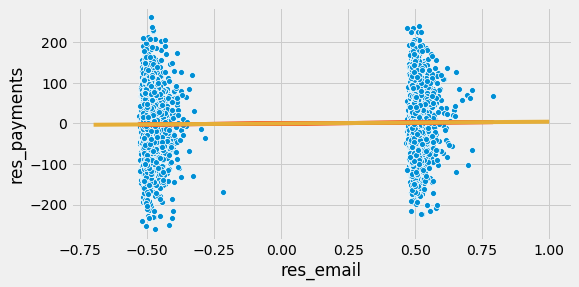

In [116]:
# 画图查看一下新的这个residual回归
plt.figure(figsize=(8,4))
# 原始数据，散点图(x,y)
sns.scatterplot("res_email","res_payments",data=residuals)  
# 线性回归数据
residuals=residuals.assign(y_hat=model_treatment.fittedvalues)
plt.plot("res_email","y_hat",data=residuals,c="C1")
#自己构造线性回归数据
x=np.linspace(-0.7,1)
y=model_treatment.params[0]+model_treatment.params[1]*x
plt.plot(x,y,c="C2")


In [117]:
# 2. 加入control 一步到位
model_2=smf.ols("payments ~ email + credit_limit + risk_score", data= data).fit()
print(model_2.summary().tables[1])

                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      490.8653      9.715     50.527      0.000     471.820     509.911
email            4.4304      2.130      2.080      0.038       0.255       8.606
credit_limit     0.1511      0.008     18.833      0.000       0.135       0.167
risk_score      -8.0516     38.424     -0.210      0.834     -83.379      67.276


# 2. 加入一些有害的control

In [118]:
# 1.读取数据
hospital=pd.read_csv("C:/Users/62678/Desktop/Causal/data/hospital_treatment.csv")
hospital.head()

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


In [120]:
# 2. 进行简单回归
hosp_1=smf.ols("days ~ treatment", data=hospital).fit()
print(hosp_1.summary().tables[1])


                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.2667      2.662     12.498      0.000      27.968      38.566
treatment     14.1533      3.367      4.204      0.000       7.451      20.856


#结果发现：治疗反而会增加住院天数。 这可能是由于我们是在两家不同的医院来进行数据采集的，不同的医院有不同的严重程度。
#现在要分开医院来回归

In [125]:
hosp_2=smf.ols("days~ treatment", data=hospital.query("hospital==1")).fit()
print(hosp_2.summary().tables[1])

hosp_3=smf.ols("days~ treatment", data=hospital.query("hospital==0")).fit()
print(hosp_3.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.0000      6.747      8.745      0.000      45.442      72.558
treatment    -10.3958      6.955     -1.495      0.141     -24.371       3.580
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.4074      2.868     10.602      0.000      24.523      36.292
treatment    -11.4074     10.921     -1.045      0.306     -33.816      11.001


#分开医院回归以后，发现结果正常了：治疗会减少住院天数。
#但是由于分开回归，数据点减少了，则不显著。

In [144]:
# 子分类估计器所使用的权重是 该组的个体数
t1=len(hospital.query("hospital==1"))
t2=len(hospital.query("hospital==0"))
ATE1=(hosp_2.params[1]* t1 + hosp_3.params[1]* t2)/(t1+t2)
print("子分类估计器：",ATE1)

# 回归估计器用的是该组的 T 的方差有关的一个权重
q1= np.var(hospital.query("hospital==1").treatment)
q2= np.var(hospital.query("hospital==0").treatment)
ATE2=(hosp_2.params[1]* q1 + hosp_3.params[1]* q2)/(q1+q2)
print("回归估计器：",ATE2)

# 如果我们把hospiital 加入为control
hosp_4=smf.ols("days~ treatment + hospital ", data=hospital).fit()
print(hosp_4.summary().tables[1])

子分类估计器： -10.76252893518518
回归估计器： -10.939038377721188
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.3654      2.419     12.555      0.000      25.549      35.182
treatment    -10.7978      5.930     -1.821      0.073     -22.607       1.011
hospital      29.0130      5.972      4.858      0.000      17.120      40.906


In [145]:
# 3. 尝试加入severity(假设这是正确的 confunder)
hosp_4=smf.ols("days~ treatment + severity",data=hospital).fit()
hosp_4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.6641,2.000,5.832,0.000,7.681,15.647
treatment,-7.5912,2.269,-3.345,0.001,-12.110,-3.073
severity,2.2741,0.154,14.793,0.000,1.968,2.580


In [146]:
# 此时再加入hospital
hosp_5=smf.ols("days~ treatment + severity + hospital",data=hospital).fit()
hosp_5.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.0111,2.118,5.198,0.000,6.792,15.230
treatment,-5.0945,3.492,-1.459,0.149,-12.049,1.861
severity,2.3865,0.195,12.251,0.000,1.999,2.774
hospital,-4.1535,4.413,-0.941,0.350,-12.943,4.636


#发现结果不对了。treatment 的SE变大 从 2.269变为了3.3492.
#分两步来看上面的这个结果。

In [148]:
# 对于这两个control（severity + hospital） 分两步来看
model_treatment=smf.ols("treatment ~severity + hospital",data=hospital).fit()
model_days=smf.ols("days ~severity + hospital",data=hospital).fit()

residuals=pd.DataFrame(dict(res_days=model_days.resid,res_treatment=model_treatment.resid))

hosp_5=smf.ols("res_days~ res_treatment",data=residuals).fit()
hosp_5.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.707e-14,0.827,4.48e-14,1.000,-1.646,1.646
res_treatment,-5.0945,3.447,-1.478,0.143,-11.957,1.768


In [150]:
# 检查下Y,X的方差
print("Treatment var:",np.var(hospital.treatment))
print("Residual Treatment var:",np.var(residuals.res_treatment))

print("Days var:",np.var(hospital.days))
print("Residual Days var:",np.var(residuals.res_days))

Treatment var: 0.234375
Residual Treatment var: 0.057529091872119076
Days var: 254.17484375000004
Residual Days var: 54.80915160573126


# 总之，当加入的control 使得方差变大不显著，则肯定是坏的control

(array([700.,  22.,  73., 115., 143., 148., 132., 117.,  84.,  58.,  40.,
         29.,  16.,   8.,   6.,   5.,   1.,   1.,   1.,   1.]),
 array([  0.        ,  40.18870849,  80.37741699, 120.56612548,
        160.75483397, 200.94354246, 241.13225096, 281.32095945,
        321.50966794, 361.69837644, 401.88708493, 442.07579342,
        482.26450191, 522.45321041, 562.6419189 , 602.83062739,
        643.01933588, 683.20804438, 723.39675287, 763.58546136,
        803.77416986]),
 <a list of 20 Patch objects>)

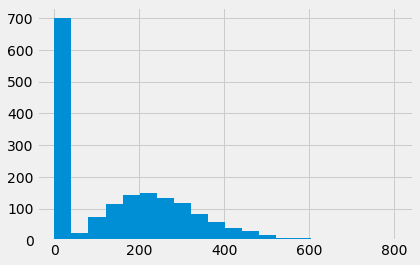

In [156]:
# 画条形统计图
data=np.concatenate([np.random.gamma(5,50,1000),np.zeros(700)]) #将1000个gamma分步的随机数和700个0连接
plt.hist(data,bins=20)